#### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# torch.set_printoptions(sci_mode=False, )
np.set_printoptions(suppress=True)

from clonaltrans import pl, utils
import os

%load_ext autoreload
%autoreload 2

#### Some Explorations 

In [2]:
paga, array_total = utils.get_topo_obs('./data/')

Topology graph loaded (11, 11).
Input cell data (num_timepoints 3, num_clones 10, num_populations 11) loaded.
Day0 has been added. Input data shape: torch.Size([4, 10, 11])
Background reference cells generated. Input data shape: torch.Size([4, 11, 11])


In [4]:
paga

tensor([[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [5]:
array_total[0]

tensor([[ 85.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 75.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 68.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 65.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 60.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 55.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 45.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [550.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
       device='cuda:0')

In [8]:
(array_total.sum(0) != 0).to(torch.float32).unsqueeze(0).shape

torch.Size([1, 11, 11])

#### Test

In [ ]:
from clonaltrans import main, config

config = config.Configuration()
config.learning_rate = 0.01
config.num_epochs = 1000
config.lrs_step = 200
config.lrs_gamma = 0.5

model = main.run_model(config, torch.tensor([0.0, 3.0, 10.0, 17.0]))

In [ ]:
torch.save(model, './model.pt')

#### Evaluate

In [4]:
path = './examples/2Layers/EKMTime4LR001Epo1000LogN.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")
model.config.input_form = 'log'

There are 3 observed timepoints except the inital time.


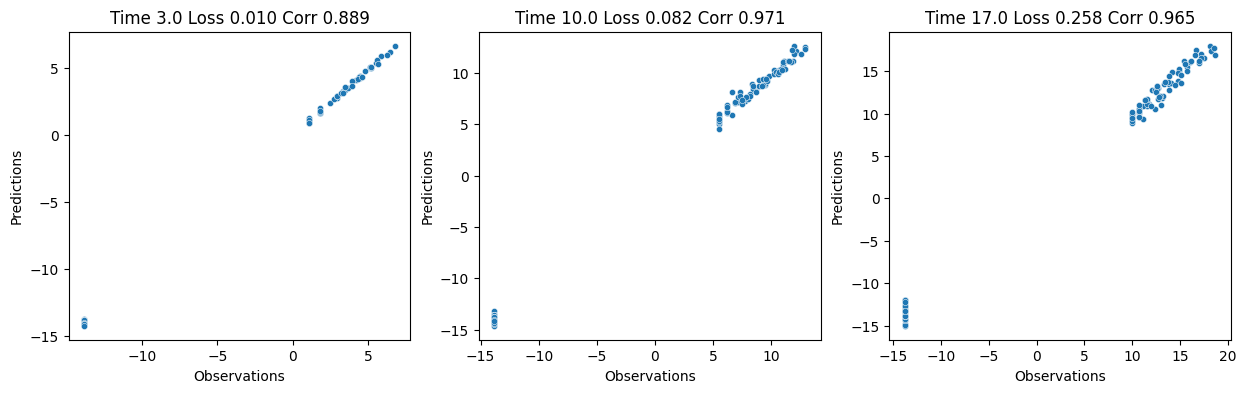

In [21]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)
t_observed_norm = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])
predictions = model.eval_model(t_observed_norm, log_output=True)

save = 'eval_' + os.path.split(path)[1]
pl.mse_corr(model.input_N[1:], predictions[1:], t_observed[1:], save=False)

#### Timepoints Smoothing

In [7]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)

x = np.linspace(0, 17, 100)
t_pred = torch.tensor(x).to(device)
t_pred_norm = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred_norm, log_output=False)

In [27]:
model.N[:, 0, 1]

tensor([    0.,   171.,   513., 21825.], device='cuda:0')

In [28]:
torch.log(model.N[:, 0, 1])

tensor([  -inf, 5.1417, 6.2403, 9.9908], device='cuda:0')

In [31]:
model.N[:, 1, 7]

tensor([   0.,  247., 7705.,    0.], device='cuda:0')

In [30]:
torch.log(model.N[:, 1, 7])

tensor([  -inf, 5.5094, 8.9496,   -inf], device='cuda:0')

In [36]:
torch.log(predictions[:, 1, 7].max())

tensor(12.1622, device='cuda:0')

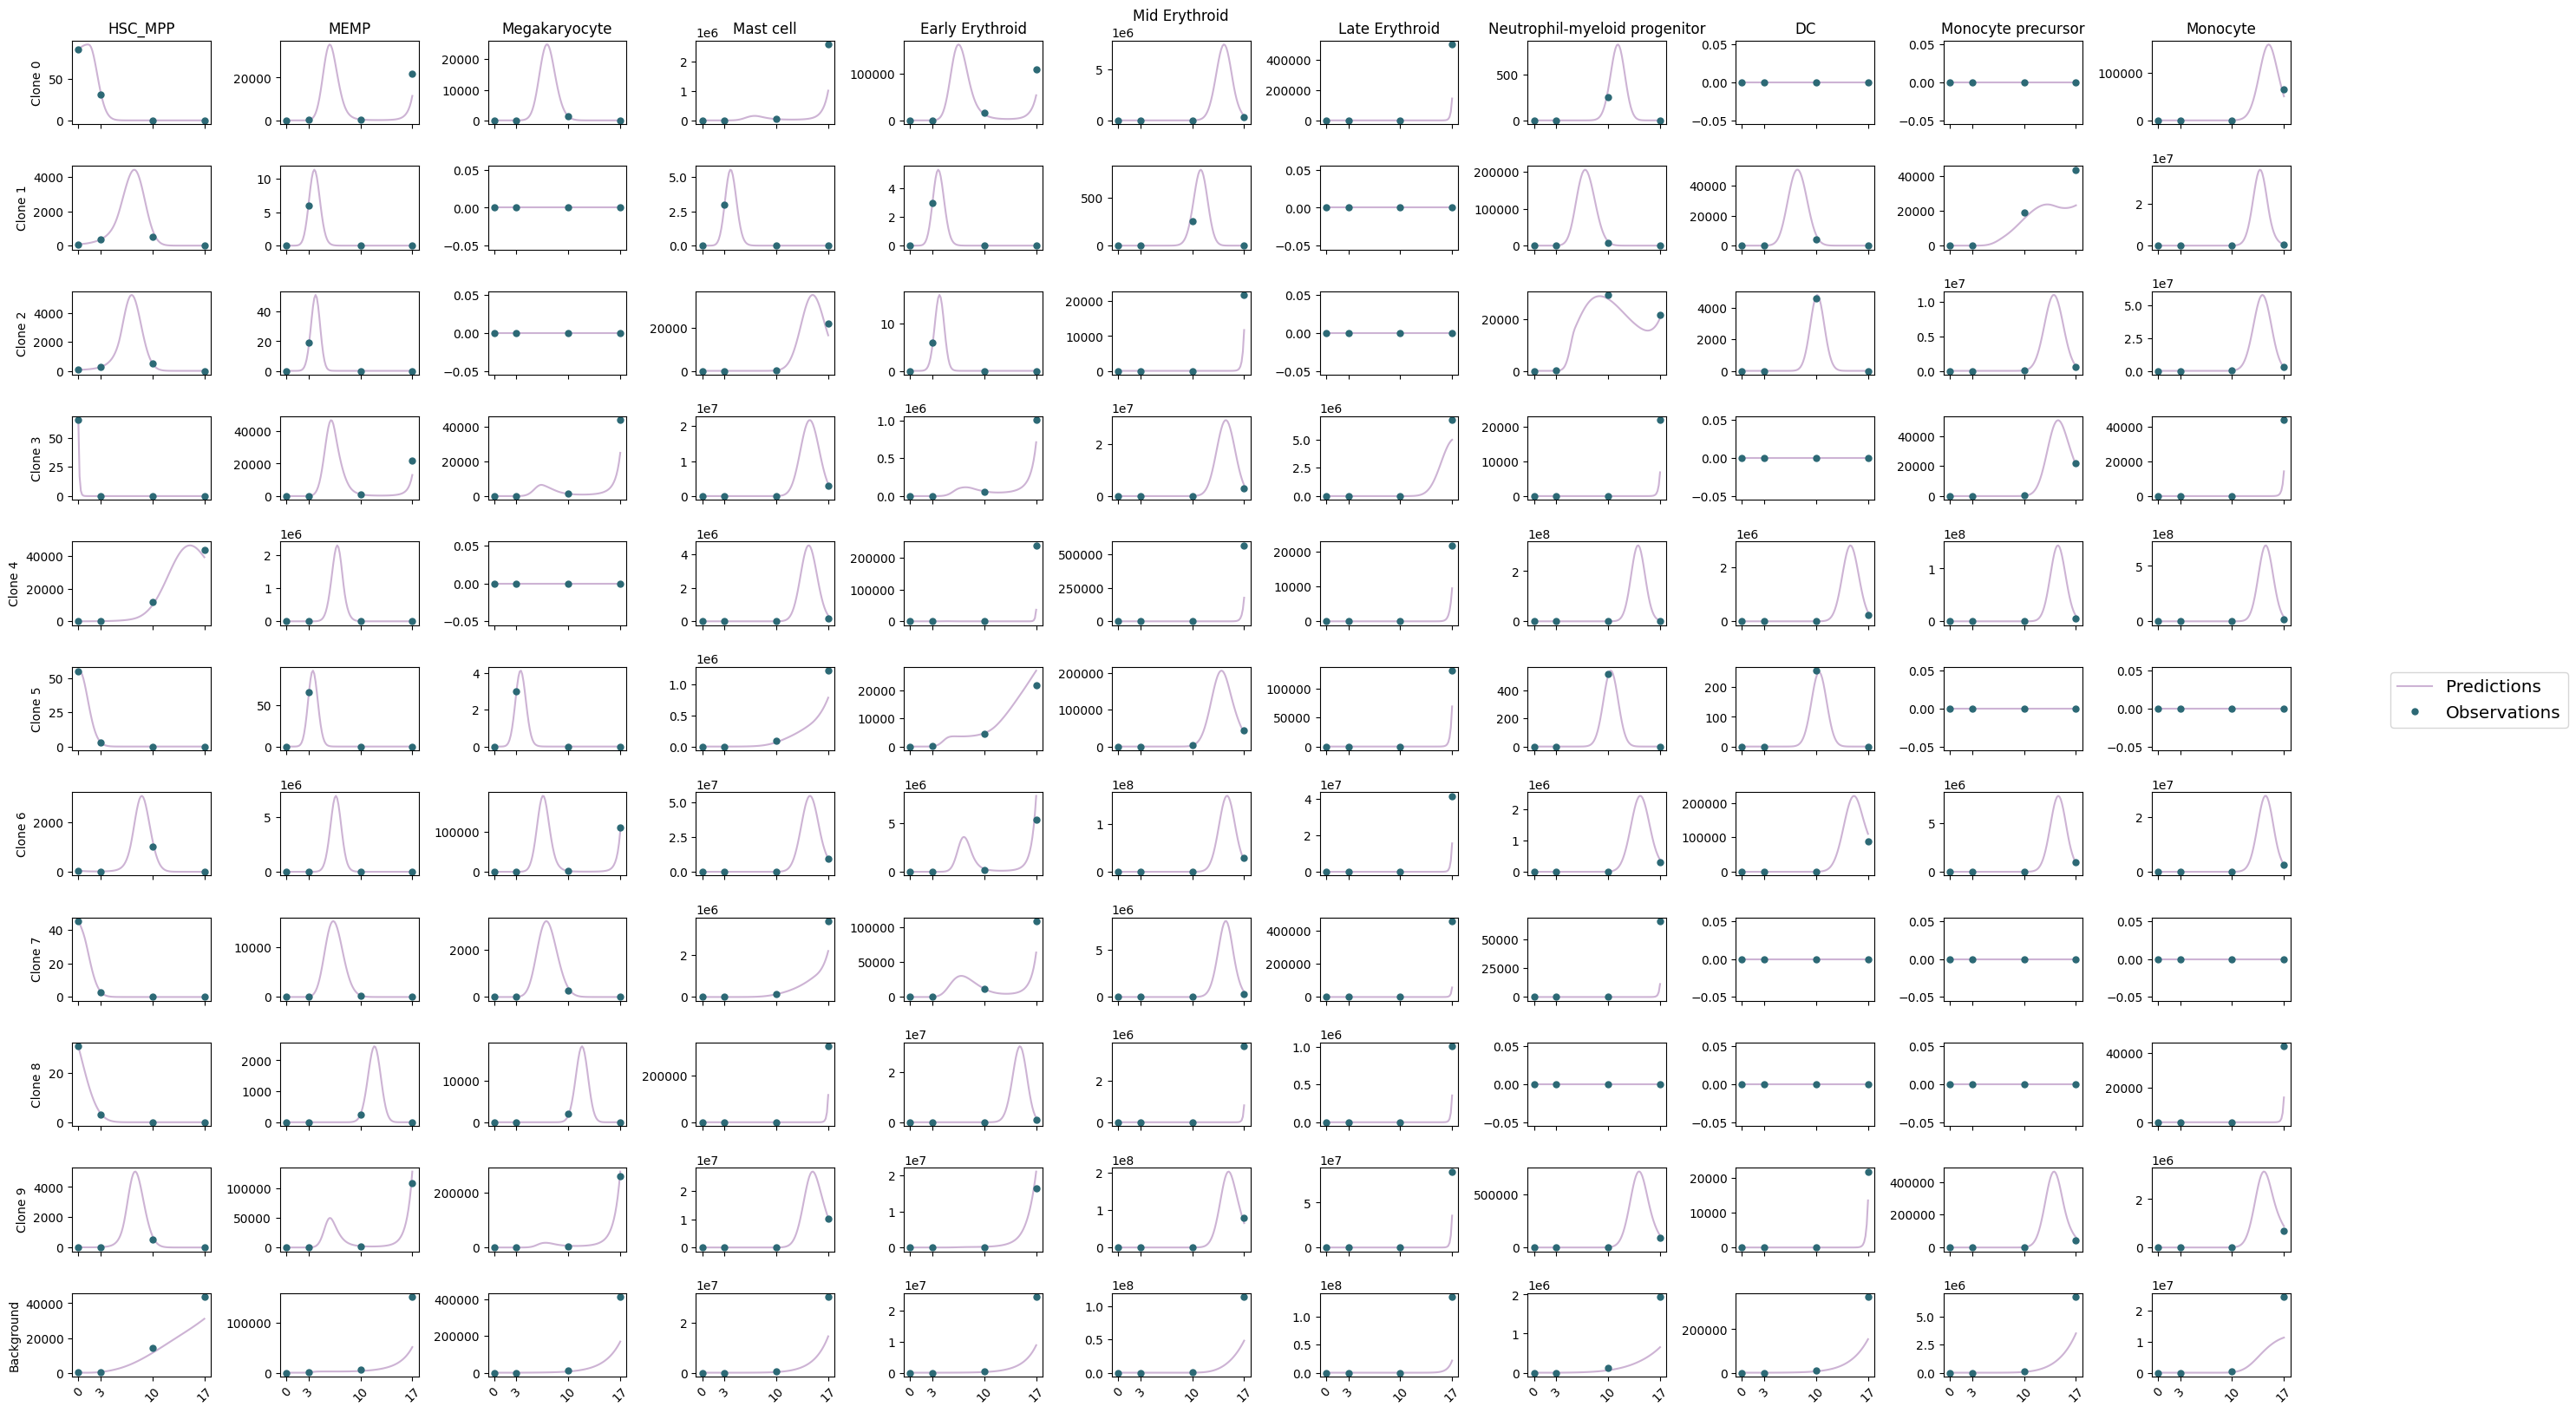

In [8]:
save = os.path.split(path)[1]
pl.grid_visual_interpolate(model.N, predictions, t_observed, t_pred, save=False)

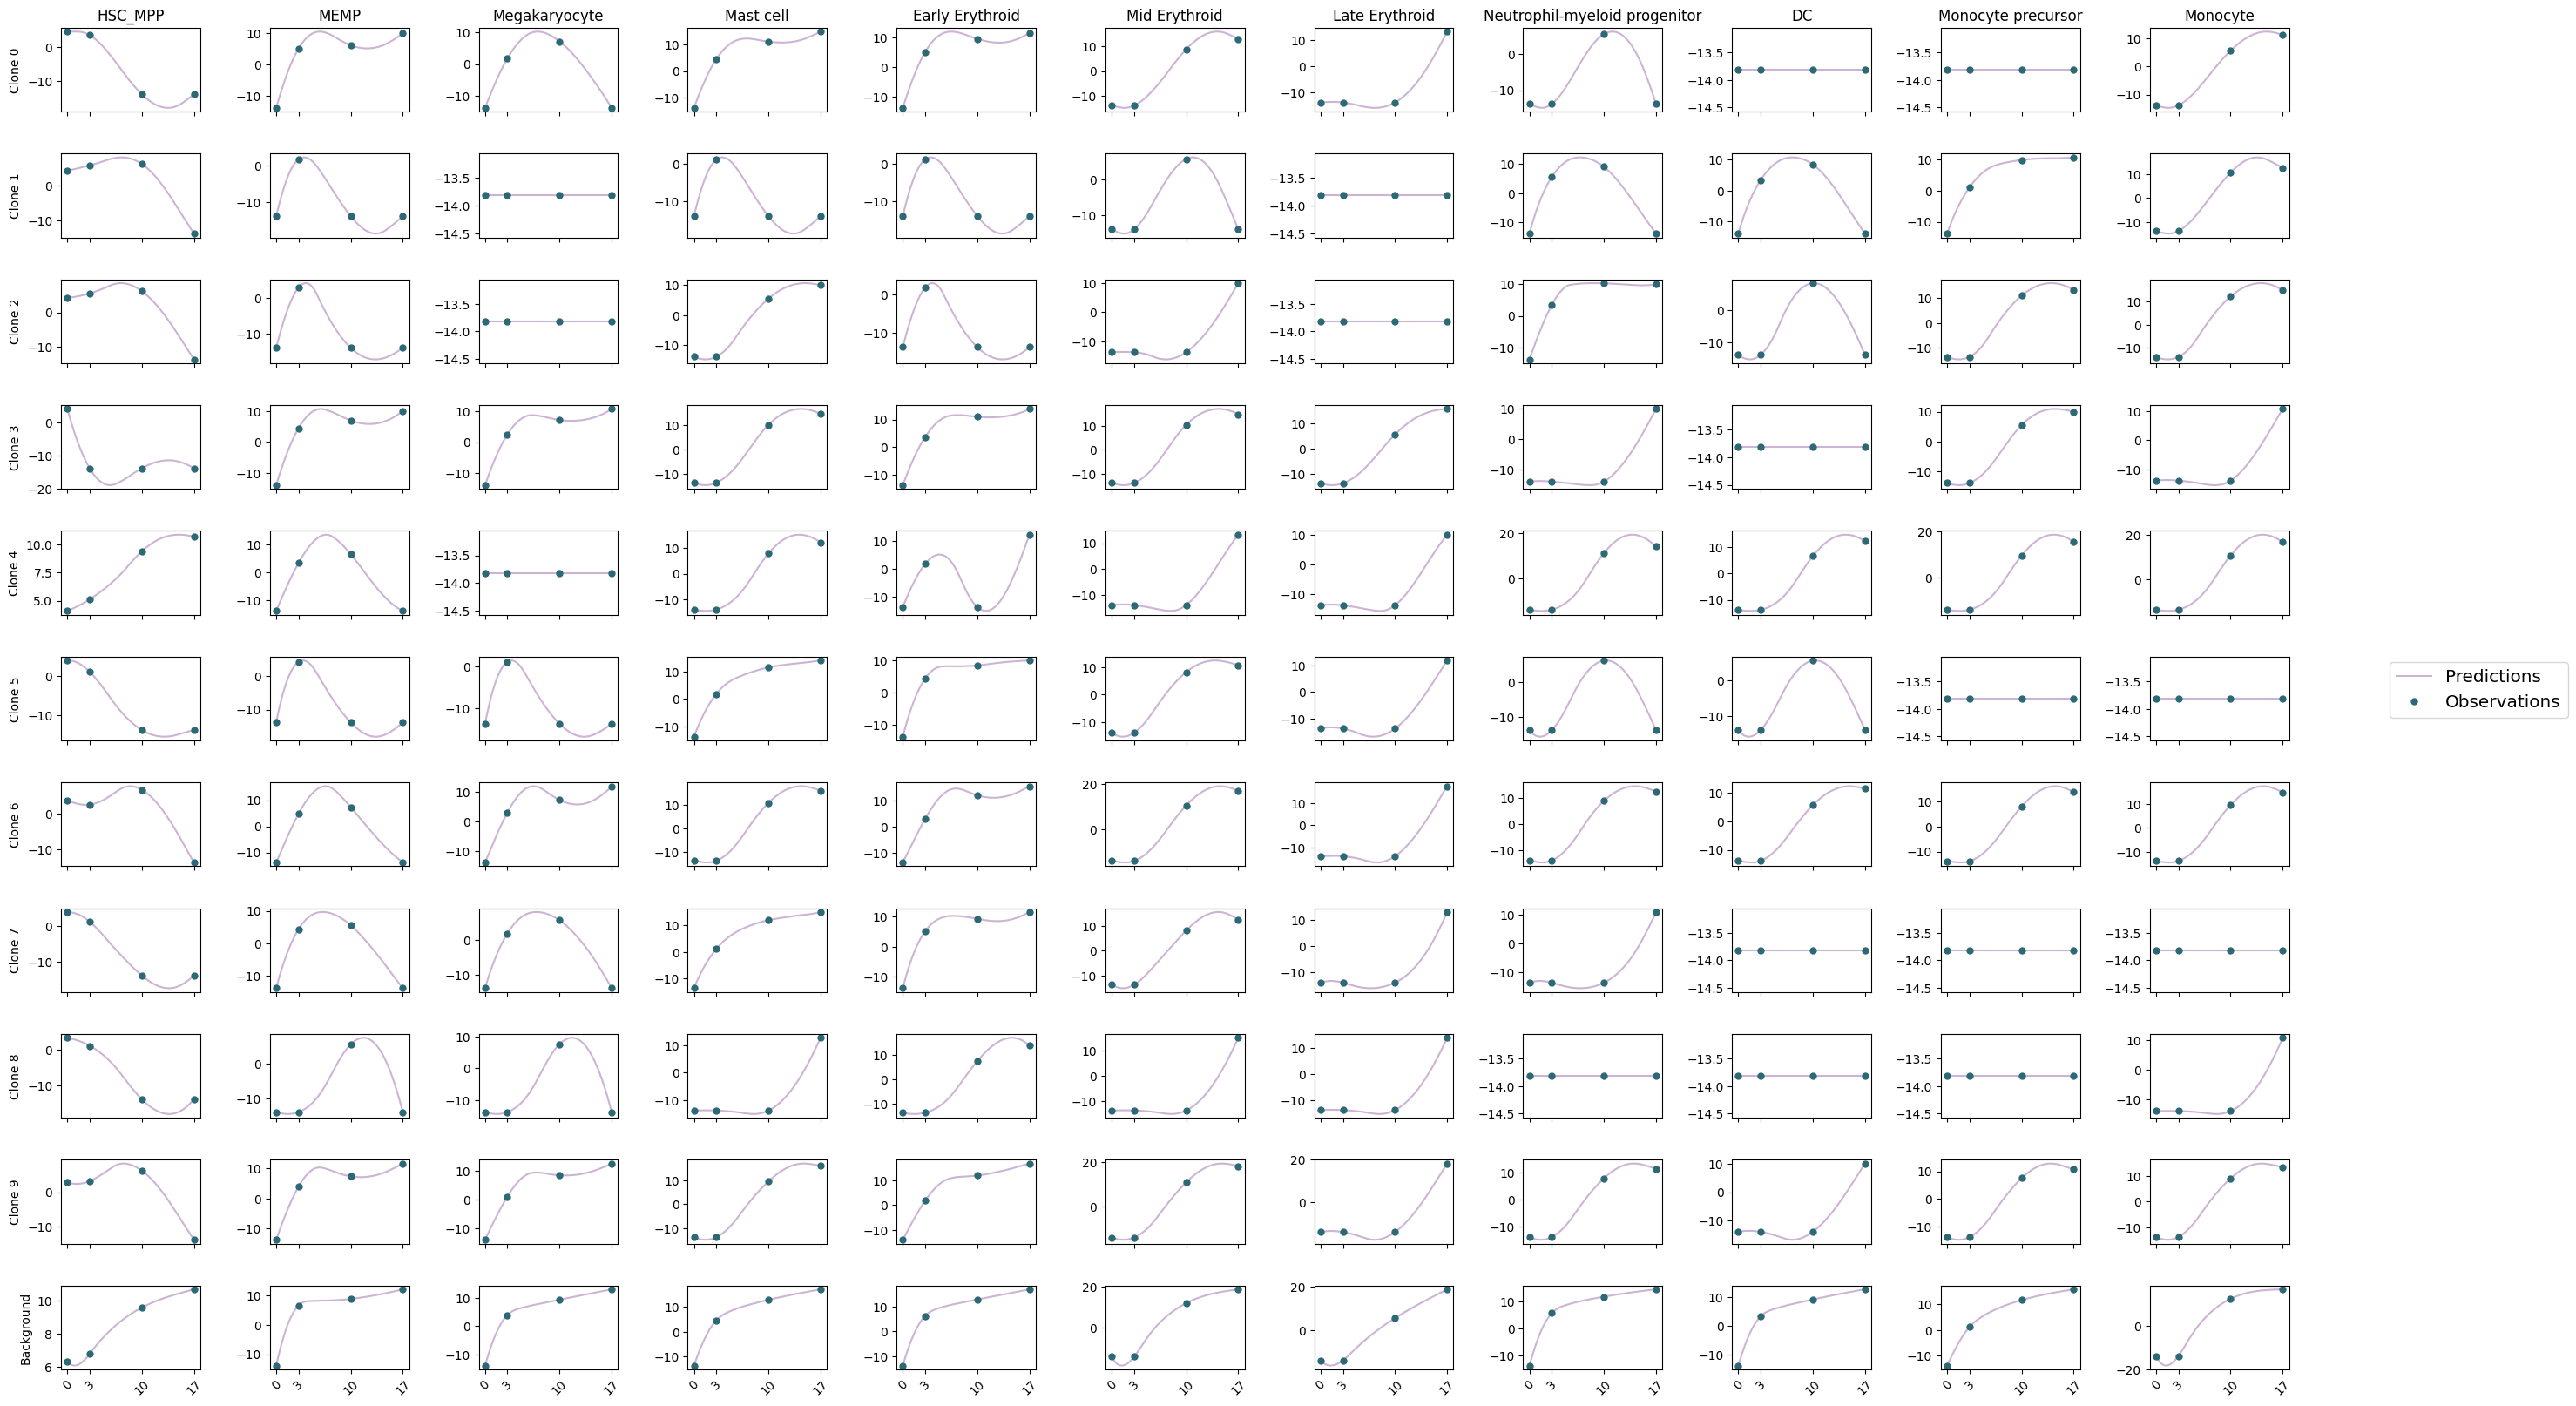

In [20]:
save = os.path.split(path)[1]
pl.grid_visual_interpolate(model.input_N, predictions, t_observed, t_pred, save=False)

#### Evaluate 1 Layer Log

In [49]:
path = './examples/1Layers/EKMTime4LR001Epo1000LogN.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")
model.config.log_data = True

There are 3 observed timepoints except the inital time.


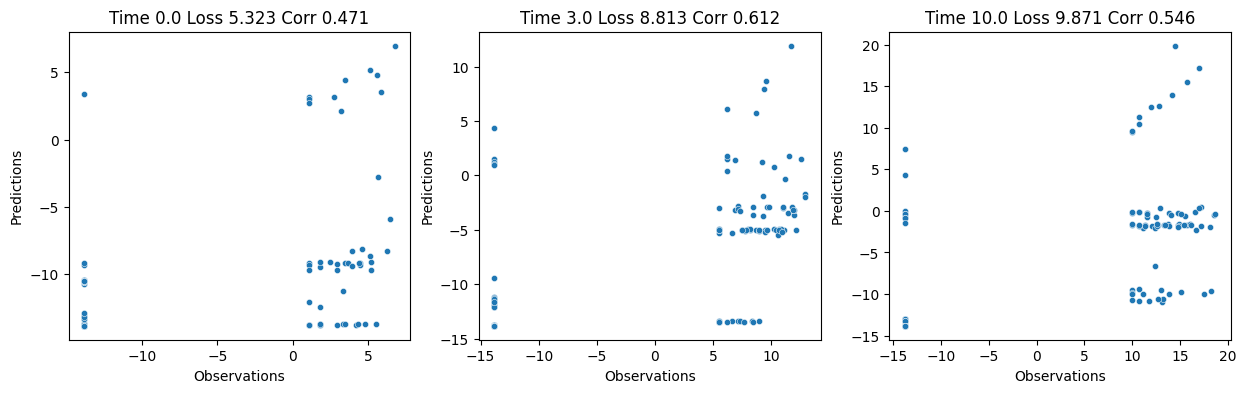

In [40]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)
t_observed_norm = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])
predictions = model.eval_model(t_observed_norm, log_output=True)

save = 'eval_' + os.path.split(path)[1]
pl.mse_corr(model.input_N[1:], predictions[1:], t_observed, save=save)

#### Timepoints Smoothing

In [41]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)

x = np.linspace(0, 17, 100)
t_pred = torch.tensor(x).to(device)
t_pred_norm = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred_norm, log_output=True)

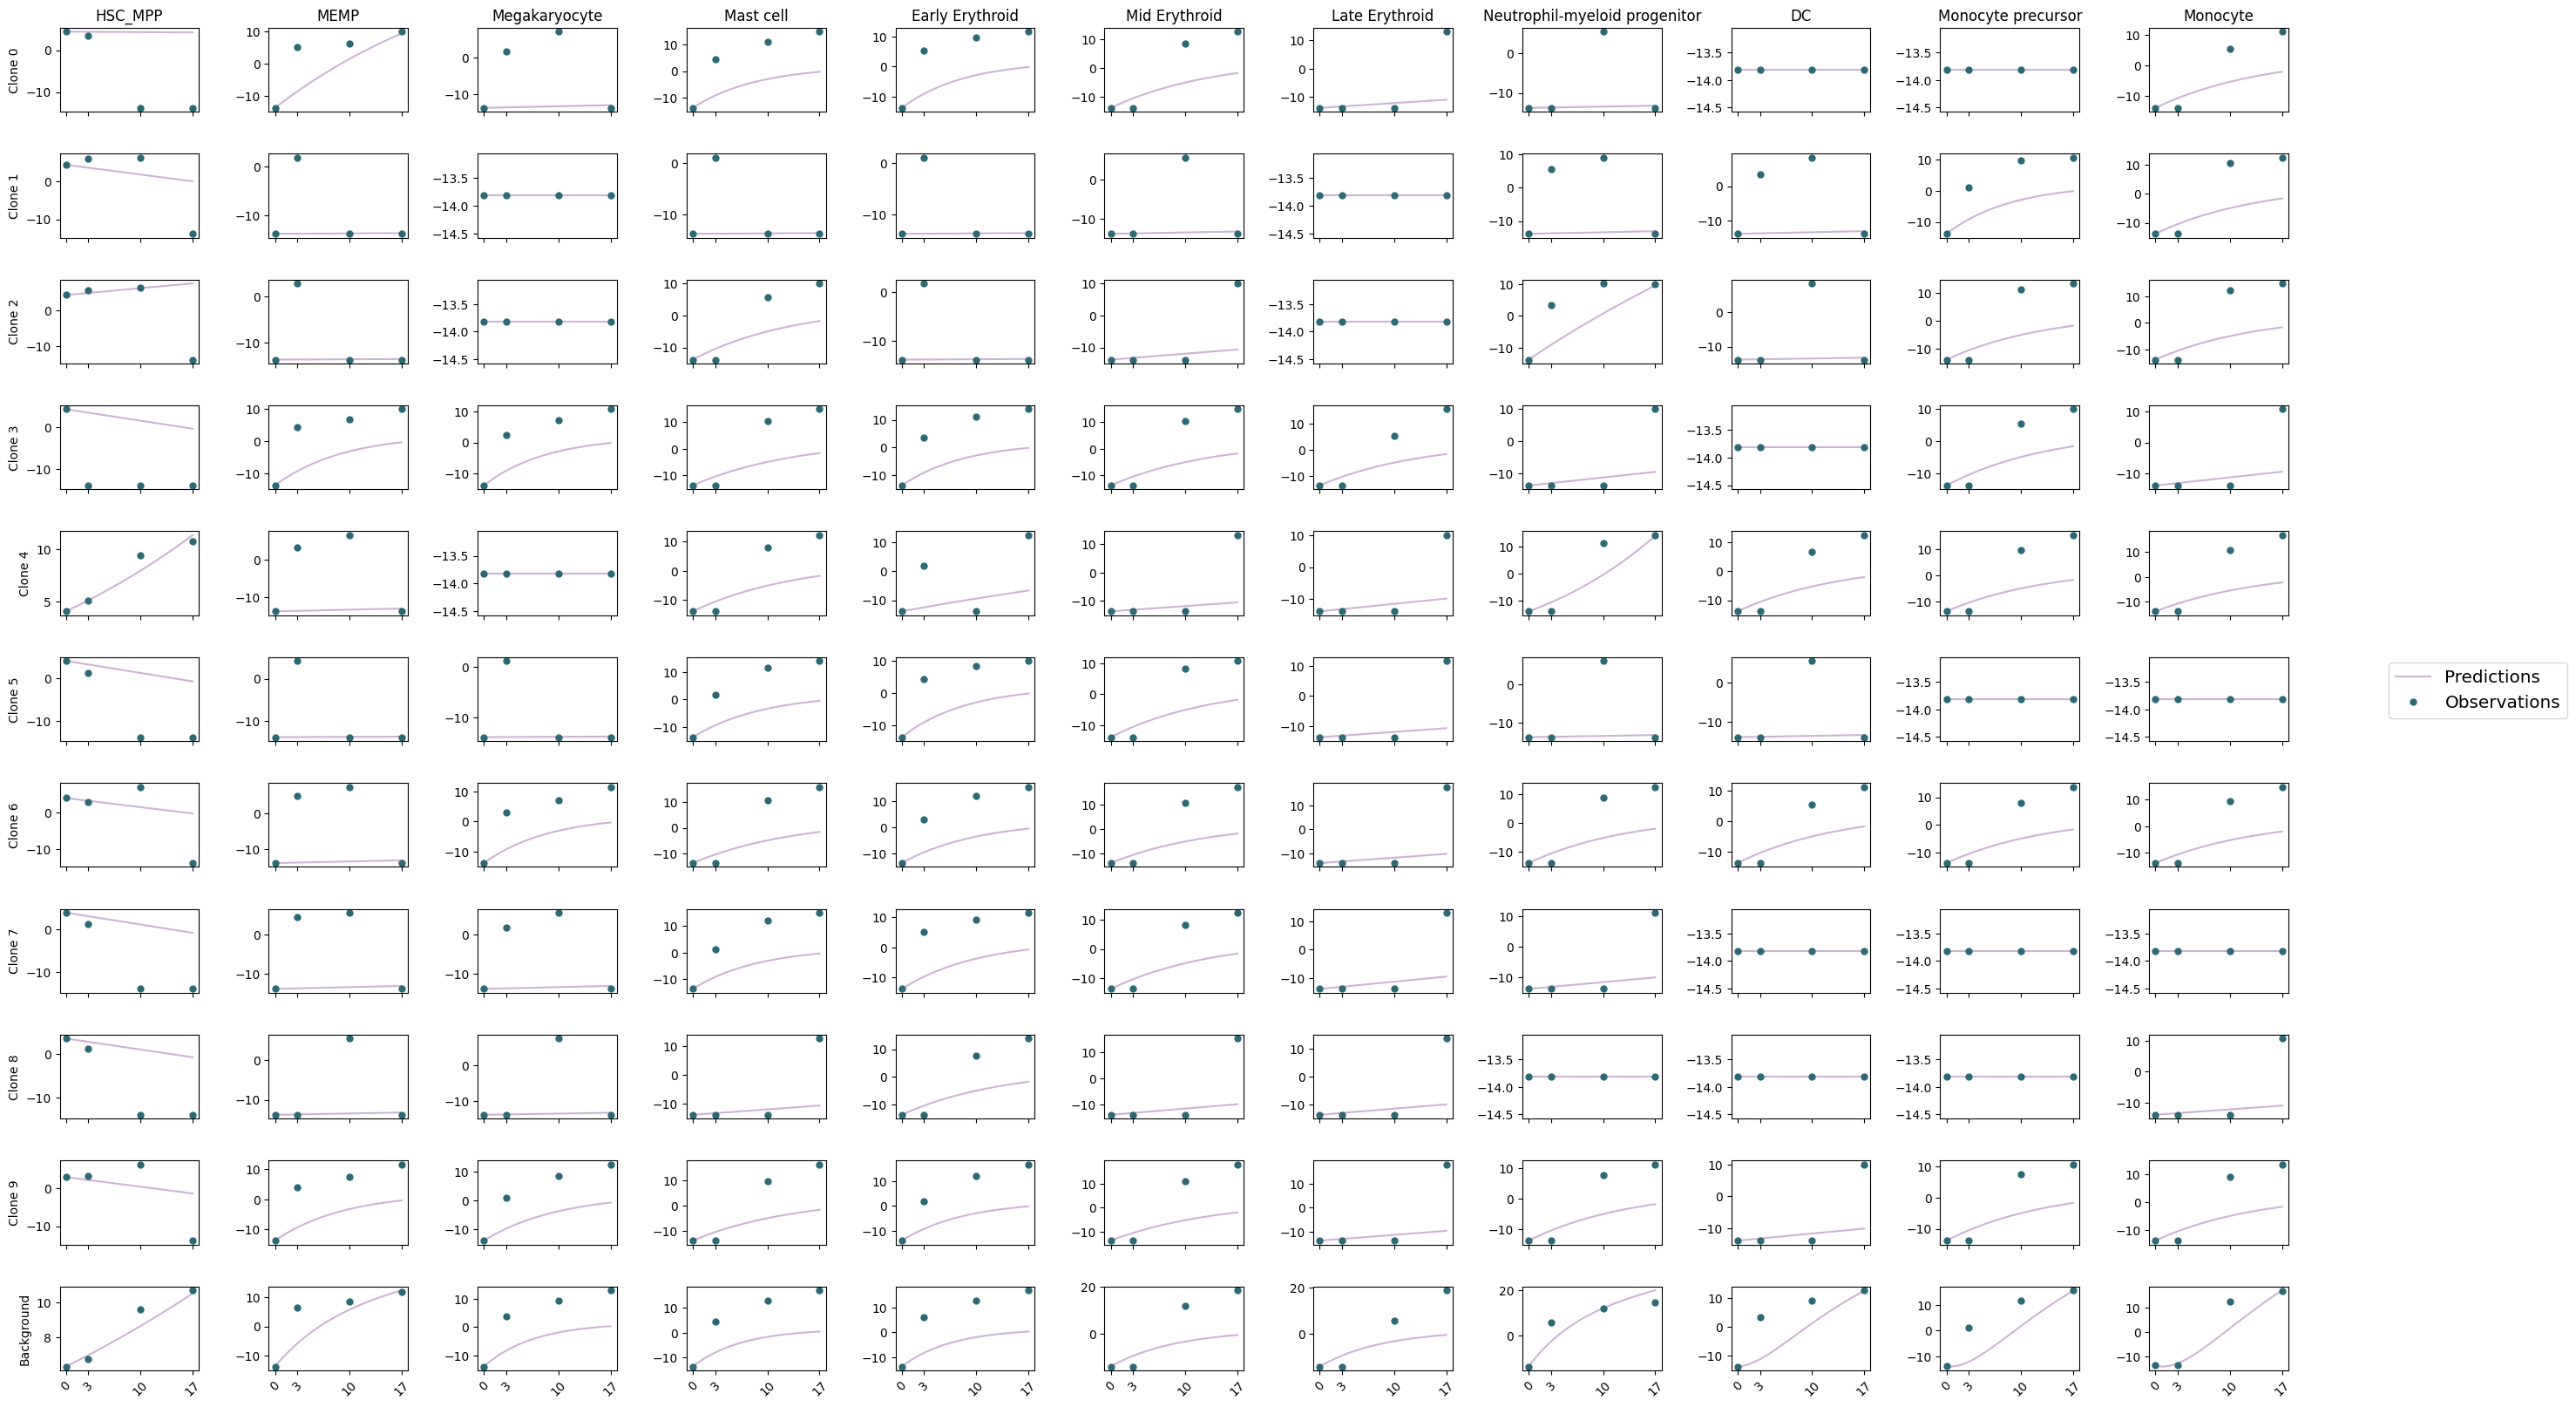

In [43]:
save = os.path.split(path)[1]
pl.grid_visual_interpolate(model.input_N, predictions, t_observed, t_pred, save=False)

#### Analysis

In [44]:
K = model.get_matrix_K()
anno = pd.read_csv('./data/annotations.csv')

In [54]:
model.ode_func.offset[9]

tensor([-4.3005,  3.8930,  3.8272,  3.9922,  3.9577,  3.6559,  4.1211,  3.8857,
         3.7607,  4.0030,  3.9510], device='cuda:1', grad_fn=<SelectBackward0>)

<AxesSubplot: >

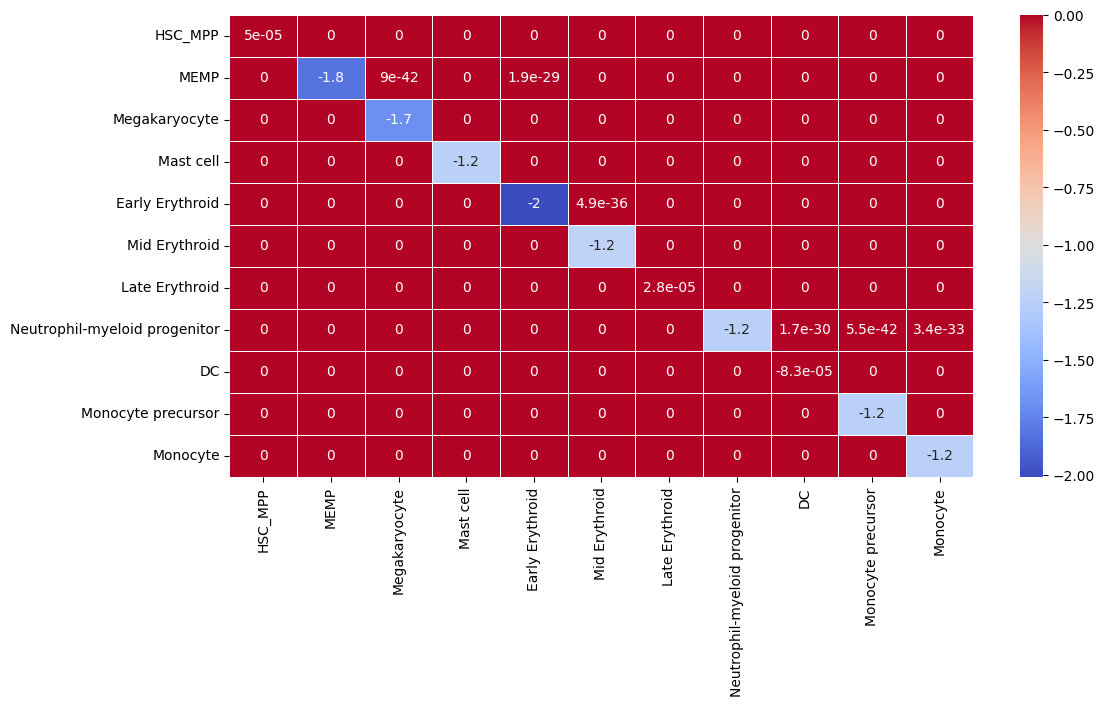

In [53]:
transition_K = pd.DataFrame(
    index=anno['populations'].values, 
    columns=anno['populations'].values, 
    data=K.detach().cpu().numpy()[9]
)
fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(transition_K, annot=True, linewidths=.5, cmap='coolwarm', ax=axes)